In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
os.chdir('..')
import functions.helperfunctions as hf

In [2]:
ff1 = 'data/output/pairing_MI-IPA/confidence_screen/'

In [3]:
allresults = []
for f in os.listdir(ff1):
    if '.csv' in f:
        print(f)
        f1 = f.replace('small_ind', 'smallInd')
        f1 = f1.replace('prop_test', 'propTest')
        properties = {x.split('-')[0]:x.split('-')[1] for x in f1.split('_') if '.csv' not in x}
        results, N = hf.load_df_TPR(ff1 + f)
        results = pd.DataFrame(np.array(np.array([x for x in results])))
        its = results.shape[1]-1
        results['test_size'] = N
        results['final_test'] = results[its]
        results['final_test_prop'] = results[its] / N
        results['epitope'] = properties['epitope']
        results['confidence'] = properties['confidence']
        results[r'$\lambda$'] = properties['L']
        allresults.append(results)

epitope-YLQPRTFLL_weights-0.6_L-1.0_method-None_prop_test-all_confidence-hungarian_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-GLCTLVAML_weights-0.6_L-1.0_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-GLCTLVAML_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-GLCTLVAML_weights-0.6_L-1.0_method-None_prop_test-all_confidence-hungarian_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-YLQPRTFLL_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-YLQPRTFLL_weights-0.6_L-1.0_method-None_prop_test-all_confidence-greedy_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-GLCTLVAML_weights-0.6_L-0.6_method-None_prop_test-all_confiden

In [4]:
all_results = pd.concat(allresults)

In [5]:
Rmelt = pd.melt(all_results, id_vars = ['epitope', 'confidence', r'$\lambda$', 'final_test_prop', 'final_test', 'test_size'])

Lineplots for everything

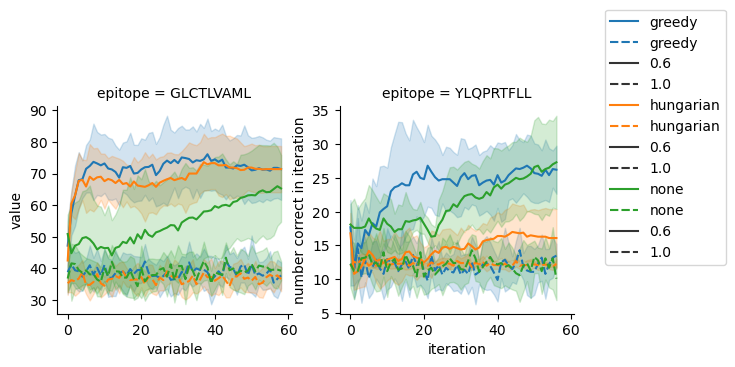

In [6]:
Rmelt = Rmelt.sort_values(by = ['epitope','confidence',r'$\lambda$'])
Rmelt['L'] = Rmelt[r'$\lambda$'].astype('str')
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
# d = {'color':sns.color_palette('flare',5) + ['black'], 'ls' : ['-', '--', '-.', ':', '--', '-']}
g = sns.FacetGrid(Rmelt[['epitope','confidence','variable','value']],
                col = 'epitope', hue='confidence', col_wrap=2, sharey=False)
g.map_dataframe(sns.lineplot, 'variable', 'value', style=Rmelt[r'$\lambda$'], style_order=['0.6','1.0'], errorbar = 'sd')
plt.legend(bbox_to_anchor = [1.1,1.5], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('number correct in iteration')
plt.show()

A single plot to show summary performance

In [7]:
from scipy.stats import ttest_ind

In [8]:
rmelt1 = Rmelt[['final_test_prop','epitope','confidence',r'$\lambda$']].drop_duplicates()

In [9]:
ttests = dict(zip(rmelt1['epitope'].unique(), [{},{}]))

for ep in rmelt1['epitope'].unique():
    for c in rmelt1['confidence'].unique():
        s1 = rmelt1.loc[(rmelt1['epitope'] == ep) & (rmelt1['confidence'] == c) & (rmelt1[r'$\lambda$'] == '0.6')]['final_test_prop']
        s2 = rmelt1.loc[(rmelt1['epitope'] == ep) & (rmelt1['confidence'] == c) & (rmelt1[r'$\lambda$'] == '1.0')]['final_test_prop']
        p = ttest_ind(s1, s2, alternative='greater').pvalue
        ttests[ep][c] = p

In [10]:
ttests

{'GLCTLVAML': {'greedy': 6.967104553097264e-08,
  'hungarian': 2.635405555890383e-08,
  'none': 2.2198089353702667e-06},
 'YLQPRTFLL': {'greedy': 2.2686745574611187e-05,
  'hungarian': 0.18693437456680728,
  'none': 0.00020624740577465943}}

In [11]:
ttests1 = dict(zip(rmelt1['epitope'].unique(), [{},{}]))

for ep in rmelt1['epitope'].unique():
    for c in ['hungarian', 'greedy']:
        s1 = rmelt1.loc[(rmelt1['epitope'] == ep) & (rmelt1['confidence'] == c) & (rmelt1[r'$\lambda$'] == '0.6')]['final_test_prop']
        s2 = rmelt1.loc[(rmelt1['epitope'] == ep) & (rmelt1['confidence'] == 'none') & (rmelt1[r'$\lambda$'] == '0.6')]['final_test_prop']
        p = ttest_ind(s1, s2, alternative='greater').pvalue
        ttests1[ep][c] = p

print(ttests1)

{'GLCTLVAML': {'hungarian': 0.15317315761910077, 'greedy': 0.09785270838728077}, 'YLQPRTFLL': {'hungarian': 0.9988723379760239, 'greedy': 0.6352436762857216}}


{'greedy': 0, 'hungarian': 1, 'none': 2}


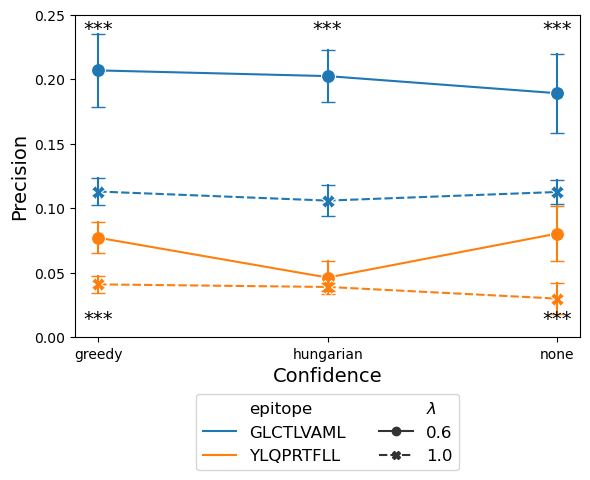

In [12]:
f, ax = plt.subplots(ncols=1, sharey=True, figsize=(6,5))
sns.lineplot(rmelt1, x = 'confidence', y = 'final_test_prop', hue = 'epitope', style=r'$\lambda$', markers=True, 
                markersize = 10, errorbar = 'sd', ax = ax,
                err_style='bars', err_kws = {'capsize':5})
confmap = {x.get_text():x.get_position()[0] for x in ax.get_xticklabels()}
print(confmap)
ax.legend(bbox_to_anchor = [1,1], loc='upper left')
ax.set_xlabel(r'Confidence', fontdict={'size':14})
ax.set_ylabel('Precision', fontdict={'size':14})
for ep in rmelt1['epitope'].unique():
    for c in rmelt1['confidence'].unique():
        if ep[0] == 'G':
            y = 0.235
        else:
            y = 0.01
        x = confmap[c]
        s = '' if ttests[ep][c] > 0.05 else '***' if ttests[ep][c] < 0.001 else '**' if ttests[ep][c] < 0.01 else '*'
        ax.text(x, y, s, horizontalalignment = 'center', fontdict={'size':14})
        if c != 'none':
            if ep[0] == 'G':
                y = 0.17
            else:
                y = 0.05
            s = '' if ttests1[ep][c] > 0.05 else '***' if ttests1[ep][c] < 0.001 else '**' if ttests1[ep][c] < 0.01 else '*'
            ax.text(x, y, s, horizontalalignment = 'center', fontdict={'size':14, 'color':'red'})
ax.set_ylim(0,0.25)
plt.legend(ncols = 2, bbox_to_anchor = [0.5,-0.15], loc = 'upper center', fontsize=12)
plt.tight_layout()
plt.savefig('figures/confidence_TPR.png',
                    bbox_inches='tight')
plt.show()

In [13]:
allresults = []
for f in os.listdir(ff1):
    if '.csv' in f:
        print(f)
        f1 = f.replace('small_ind', 'smallInd')
        f1 = f1.replace('prop_test', 'propTest')
        properties = {x.split('-')[0]:x.split('-')[1] for x in f1.split('_') if '.csv' not in x}
        results, N = hf.load_df_recall(ff1 + f)
        results = pd.DataFrame(np.array(np.array([x for x in results])))
        its = results.shape[1]-1
        results['test_size'] = N
        results['final_test'] = results[its]
        results['final_test_prop'] = results[its] / N
        results['epitope'] = properties['epitope']
        results['confidence'] = properties['confidence']
        results[r'$\lambda$'] = properties['L']
        allresults.append(results)

epitope-YLQPRTFLL_weights-0.6_L-1.0_method-None_prop_test-all_confidence-hungarian_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-GLCTLVAML_weights-0.6_L-1.0_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-GLCTLVAML_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-GLCTLVAML_weights-0.6_L-1.0_method-None_prop_test-all_confidence-hungarian_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-YLQPRTFLL_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-YLQPRTFLL_weights-0.6_L-1.0_method-None_prop_test-all_confidence-greedy_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
epitope-GLCTLVAML_weights-0.6_L-0.6_method-None_prop_test-all_confiden

In [14]:
all_results = pd.concat(allresults)

In [15]:
Rmelt = pd.melt(all_results, id_vars = ['epitope', 'confidence', r'$\lambda$', 'final_test_prop', 'final_test', 'test_size'])

Lineplots for everything

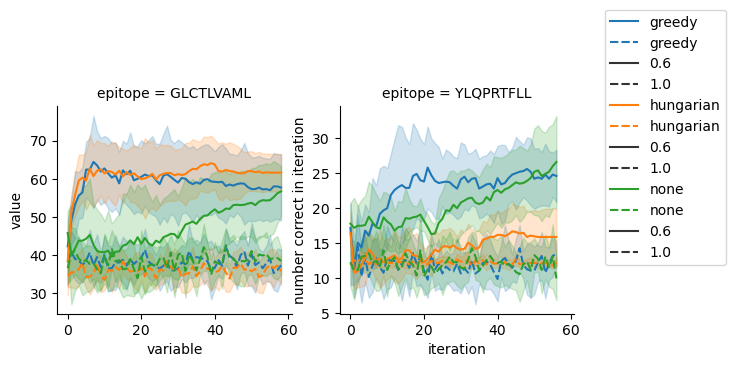

In [16]:
Rmelt = Rmelt.sort_values(by = ['epitope','confidence',r'$\lambda$'])
Rmelt['L'] = Rmelt[r'$\lambda$'].astype('str')
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
# d = {'color':sns.color_palette('flare',5) + ['black'], 'ls' : ['-', '--', '-.', ':', '--', '-']}
g = sns.FacetGrid(Rmelt[['epitope','confidence','variable','value']],
                col = 'epitope', hue='confidence', col_wrap=2, sharey=False)
g.map_dataframe(sns.lineplot, 'variable', 'value', style=Rmelt[r'$\lambda$'], style_order=['0.6','1.0'], errorbar = 'sd')
plt.legend(bbox_to_anchor = [1.1,1.5], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('number correct in iteration')
plt.show()

A single plot to show summary performance

In [17]:
from scipy.stats import ttest_ind

In [18]:
rmelt1 = Rmelt[['final_test_prop','epitope','confidence',r'$\lambda$']].drop_duplicates()

In [19]:
ttests = dict(zip(rmelt1['epitope'].unique(), [{},{}]))

for ep in rmelt1['epitope'].unique():
    for c in rmelt1['confidence'].unique():
        s1 = rmelt1.loc[(rmelt1['epitope'] == ep) & (rmelt1['confidence'] == c) & (rmelt1[r'$\lambda$'] == '0.6')]['final_test_prop']
        s2 = rmelt1.loc[(rmelt1['epitope'] == ep) & (rmelt1['confidence'] == c) & (rmelt1[r'$\lambda$'] == '1.0')]['final_test_prop']
        p = ttest_ind(s1, s2, alternative='greater').pvalue
        ttests[ep][c] = p

In [20]:
ttests

{'GLCTLVAML': {'greedy': 0.0003894707724834801,
  'hungarian': 7.400236041626617e-08,
  'none': 4.571220336070579e-05},
 'YLQPRTFLL': {'greedy': 2.3163323347764198e-05,
  'hungarian': 0.13979553074944412,
  'none': 0.00021369994783042865}}

In [21]:
ttests1 = dict(zip(rmelt1['epitope'].unique(), [{},{}]))

for ep in rmelt1['epitope'].unique():
    for c in ['hungarian', 'greedy']:
        s1 = rmelt1.loc[(rmelt1['epitope'] == ep) & (rmelt1['confidence'] == c) & (rmelt1[r'$\lambda$'] == '0.6')]['final_test_prop']
        s2 = rmelt1.loc[(rmelt1['epitope'] == ep) & (rmelt1['confidence'] == 'none') & (rmelt1[r'$\lambda$'] == '0.6')]['final_test_prop']
        p = ttest_ind(s1, s2, alternative='greater').pvalue
        ttests1[ep][c] = p

print(ttests1)

{'GLCTLVAML': {'hungarian': 0.11387089864059964, 'greedy': 0.6082092980539503}, 'YLQPRTFLL': {'hungarian': 0.9966993187426342, 'greedy': 0.6214019868869611}}


{'greedy': 0, 'hungarian': 1, 'none': 2}


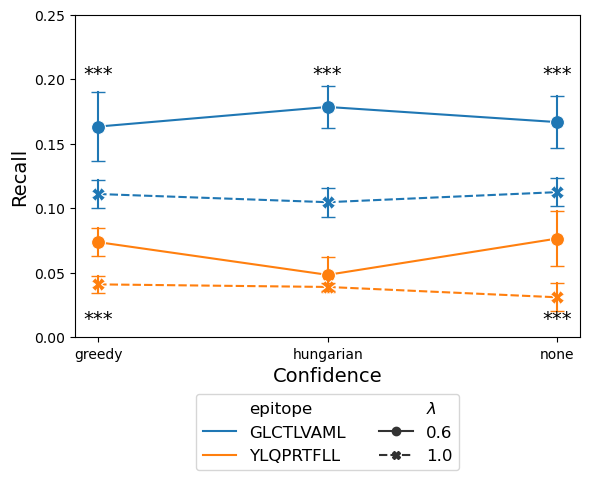

In [22]:

f, ax = plt.subplots(ncols=1, sharey=True, figsize=(6,5))
sns.lineplot(rmelt1, x = 'confidence', y = 'final_test_prop', hue = 'epitope', style=r'$\lambda$', markers=True, 
                markersize = 10, errorbar = 'sd', ax = ax,
                err_style='bars', err_kws = {'capsize':5})
confmap = {x.get_text():x.get_position()[0] for x in ax.get_xticklabels()}
print(confmap)
ax.legend(bbox_to_anchor = [1,1], loc='upper left')
ax.set_xlabel(r'Confidence', fontdict={'size':14})
ax.set_ylabel('Recall', fontdict={'size':14})
for ep in rmelt1['epitope'].unique():
    for c in rmelt1['confidence'].unique():
        if ep[0] == 'G':
            y = 0.2
        else:
            y = 0.01
        x = confmap[c]
        s = '' if ttests[ep][c] > 0.05 else '***' if ttests[ep][c] < 0.001 else '**' if ttests[ep][c] < 0.01 else '*'
        ax.text(x, y, s, horizontalalignment = 'center', fontdict={'size':14})
        if c != 'none':
            if ep[0] == 'G':
                y = 0.15
            else:
                y = 0.05
            s = '' if ttests1[ep][c] > 0.05 else '***' if ttests1[ep][c] < 0.001 else '**' if ttests1[ep][c] < 0.01 else '*'
            ax.text(x, y, s, horizontalalignment = 'center', fontdict={'size':14, 'color':'red'})
ax.set_ylim(0,0.25)
plt.legend(ncols = 2, bbox_to_anchor = [0.5,-0.15], loc = 'upper center', fontsize=12)
plt.tight_layout()
plt.savefig('figures/confidence_recall.png',
                    bbox_inches='tight')
plt.show()